In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from matplotlib.patches import Ellipse

from scipy.interpolate import griddata

plt.rcParams.update({'font.size': 12})

np.random.seed(4)

from scipy import stats
from scipy.stats import norm, uniform
import scipy.optimize

In [2]:
# import internal files
import emulators
import utils
import historymatch
import plot

In [7]:
ndim = 5

In [225]:
def model_eqn_1(x, theta_0, theta_1, theta_2, theta_3, theta_4):
    return 0.5*theta_0 + 5*theta_1*(x) + 5*theta_2*(x**2) + 5*theta_3*(x**3) + theta_4*(10*x**4 - 0.5)
    
function1 = np.vectorize(model_eqn_1)

In [226]:
def model_eqn_2(x, theta_0, theta_1, theta_2, theta_3, theta_4):
    return 0.5*theta_0 - 5*theta_1*np.sin(x) + 5*theta_2*np.cos(2*x) + 5*theta_3*np.exp(x) + theta_4*(1/(2*x) - 0.5)

function2 = np.vectorize(model_eqn_2)

In [227]:
def toy_model_5D(theta_0, theta_1, theta_2, theta_3, theta_4):
    
    x_bound = np.array([0.1, 1])
    Nx = 10
    xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

    outputs =  []
    for x in xvals:
        output = 0.5*theta_0 + 5*theta_1*(x) + 5*theta_2*(x**2) + 5*theta_3*(x**3) + theta_4*(10*x**4 - 0.5)
        outputs.append(output)
    for x in xvals:
        output = 0.5*theta_0 - 5*theta_1*np.sin(x) + 5*theta_2*np.cos(2*x) + 5*theta_3*np.exp(x) + theta_4*(1/(2*x)-0.5)
        outputs.append(output)
    return np.array(outputs)

In [229]:
# define parameter space
x_bound = np.array([0.1, 1])
Nx = 10
xvals = np.linspace(x_bound[0], x_bound[-1], Nx)

parameter_bounds = np.ones((ndim,2))
parameter_bounds[:,0] = [-1, -1, -1, -1, -1]
parameter_bounds[:,1] = [1, 1, 1, 1, 1]

theta_0_vals = np.linspace(parameter_bounds[0,0], parameter_bounds[0,1], 100)
theta_1_vals = np.linspace(parameter_bounds[1,0], parameter_bounds[1,1], 100)
theta_2_vals = np.linspace(parameter_bounds[2,0], parameter_bounds[2,1], 100)
theta_3_vals = np.linspace(parameter_bounds[3,0], parameter_bounds[1,1], 100)
theta_4_vals = np.linspace(parameter_bounds[4,0], parameter_bounds[2,1], 100)



theta_vals = np.concatenate((theta_0_vals.reshape(1,-1), theta_1_vals.reshape(1,-1), \
                            theta_2_vals.reshape(1,-1), theta_3_vals.reshape(1,-1),\
                            theta_4_vals.reshape(1,-1)), axis=0)

In [245]:
# for testing: true datapoints
true_parameters = [-0.1, 0.3, 0.6, -0.4, 0.15]
ndim = len(true_parameters)

var_exp_f1 = 0.001        # observational uncertainty variance
var_exp_f2 = 0.001

error_f1 = np.random.normal(0, var_exp_f1, len(xvals))
error_f2 = np.random.normal(0, var_exp_f2, len(xvals))

#z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2])+ np.random.normal(0, var_exp_f1) # observed datapoint
z_1 = function1(xvals, true_parameters[0], true_parameters[1], true_parameters[2], true_parameters[3], true_parameters[4]) + error_f1 # observed datapoint

z_2 = function2(xvals, true_parameters[0], true_parameters[1], true_parameters[2], true_parameters[3], true_parameters[4]) + error_f2  # observed datapoint

#z_1 = function1(xvals, true_parameters[0], true_parameters[1]) + error_f1 # observed datapoint
#z_2 = function2(xvals, true_parameters[0], true_parameters[1]) + error_f2  # observed datapoint

print(z_2)

[ 1.20524229  0.27424304 -0.54193402 -1.41558655 -2.37190112 -3.40335405
 -4.50253953 -5.64607831 -6.81675645 -7.99715827]


In [246]:
def design_matrix_f1(x, p=3):
    X_d = np.zeros((len(x),p))
    for i in range(p):
        X_d[:,i] = x**i
    X_d[:,0] = 0.5
    X_d[:,1] = 5*x
    X_d[:,2] = 5*x**2
    X_d[:,3] = 5*x**3
    X_d[:,4] = 10*x**4 - 0.5
    return X_d

def design_matrix_f2(x, p=3):
    X_d = np.zeros((len(x),p))
    X_d[:,0] = 0.5
    X_d[:,1] = -5*np.sin(x)
    X_d[:,2] = 5*np.cos(2*x)
    X_d[:,3] = 5*np.exp(x)
    X_d[:,4] = 1/(2*x) - 0.5
    return X_d


# Create design matrix
X1 = design_matrix_f1(xvals, p=5)
X2 = design_matrix_f2(xvals, p=5)


In [247]:
def A_matrix(X_d, variance):
    for i in range(X_d.shape[0]):
        X_d[i] = X_d[i] / np.sqrt(variance)
    return X_d

In [248]:
A1 = A_matrix(X1, var_exp_f1)
b1 = z_1 / np.sqrt(var_exp_f1)

A2 = A_matrix(X2, var_exp_f2)
b2 = z_2 / np.sqrt(var_exp_f2)

In [249]:
def solve_theta(A, b):
    theta_best = ((np.linalg.inv(A.T.dot(A))).dot(A.T)).dot(b)
    return theta_best.flatten()

In [250]:

true_parameters = [-0.1, 0.3, 0.6, -0.4, 0.15]
thet = solve_theta(A2,b2)
print(thet)



[ 0.04823672  0.30780457  0.59241481 -0.40419468  0.14784882]


In [251]:
def H_matrix(A):
    return np.linalg.inv(A.T.dot(A))

In [252]:
def covariance(X_d, variance):
    return variance*np.linalg.inv(X_d.T.dot(X_d))

In [253]:
cov_matrix_f1 = covariance(X1, var_exp_f1)
cov_matrix_f2 = covariance(X2, var_exp_f2)
theta_f1 = solve_theta(A1, b1)
theta_f2 = solve_theta(A2, b2)

print(theta_f2)
true_thetas = [theta_f1, theta_f2]


H1 = H_matrix(A1)
H2 = H_matrix(A2)


[ 0.04823672  0.30780457  0.59241481 -0.40419468  0.14784882]


In [254]:
print(H1)

[[ 0.18770319 -0.10064103  0.34963092 -0.46153846  0.10236985]
 [-0.10064103  0.05547332 -0.18910256  0.24489769 -0.0534188 ]
 [ 0.34963092 -0.18910256  0.6654089  -0.88141026  0.19546426]
 [-0.46153846  0.24489769 -0.88141026  1.18816369 -0.26709402]
 [ 0.10236985 -0.0534188   0.19546426 -0.26709402  0.06070319]]


In [255]:
def get_cov_ellipse(cov, centre, nstd, ax, color):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(np.abs(eigvals))
    
    t = np.linspace(0, 2*np.pi, 100)
    Ell = np.array([0.5*width*np.cos(t) , 0.5*height*np.sin(t)]) 
    R_rot = np.array([[np.cos(theta) , -np.sin(theta)],[np.sin(theta), np.cos(theta)]])  
    Ell_rot = np.zeros((2,Ell.shape[1]))
    for i in range(Ell.shape[1]):
        Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])
    
    ax.plot( centre[0]+Ell_rot[0,:] , centre[1]+Ell_rot[1,:], color=color)
    #ax.plot(Ell_rot[:,0], Ell_rot[:,1])

In [256]:
def plot_ellipses(fig, parameter_bounds, true_parameters, H, theta_best, theta_vals, color):
    theta_names = [r'$\theta_{1}$', r'$\theta_{2}$', r'$\theta_{3}$', r'$\theta_{4}$', r'$\theta_{5}$']
    N = len(theta_best)
    for i in range(N):
        for j in range(N):
            ax = fig.axes[i + N*j]
            if i != 0:
                ax.axes.yaxis.set_visible(False)
                
            if i == j:
                if color == 'mediumaquamarine':
                    ax_right = ax.twinx()
                    ax_right.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                    ax_right.set_title(str(theta_names[i]) + '=' + str(round(theta_best[i], 2)), fontsize=14)
                else:
                    ax.plot(theta_vals[i], stats.norm.pdf(theta_vals[i], theta_best[i], np.sqrt(H[i,i])), color=color)
                
            elif i < j:
                
                cov_matrix = np.array([[H[i,i], H[i,j]],[H[j,i], H[j,j]]])
                get_cov_ellipse(cov_matrix, [theta_best[i], theta_best[j]], 3, ax, color)
                ax.set_ylabel(theta_names[j])
                ax.set_xlabel(theta_names[i])
                ax.set_xlim([parameter_bounds[i,0], parameter_bounds[i,1]])
                ax.set_ylim([parameter_bounds[j,0], parameter_bounds[j,1]])
                
            else:
                ax.axis('off')

(5, 100)


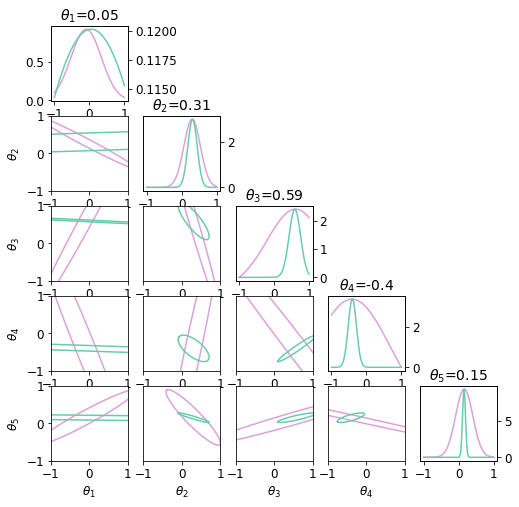

In [257]:
color_list = ['plum', 'mediumaquamarine']
N = ndim
fig, axes = plt.subplots(N,N,figsize=(8,8))

print(theta_vals.shape)
ax = fig.axes[5]
plot_ellipses(fig, parameter_bounds, true_parameters, H1, theta_f1, theta_vals, color_list[0])
plot_ellipses(fig, parameter_bounds, true_parameters, H2, theta_f2, theta_vals, color_list[1])
#ax.scatter(1,1,color=color_list[0],label='Function 1')
#ax.scatter(1,1,color=color_list[1],label='Function 2')
#ax.legend(loc='center')

In [26]:
y = [-1.534725,    8.38204167,  8.89125833,  1.95079167,  6.31150833, -3.600025,
 -3.60349167,  5.45614167, -6.99509167, -0.112125,    4.716525,   -7.15130833,
  7.51994167,  3.44409167,  3.70954167,  5.478625,   10.93034167, -2.295075,
 -5.22804167, -7.182925,    2.81965833, -1.891175,    2.92764167, -0.28214167,
  0.58490833, -2.51355833,  9.17405833,  1.569325,    1.091225,    6.63955833]

25.57448127166429


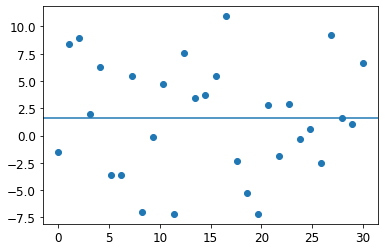

In [44]:
fig, ax = plt.subplots()
x = np.linspace(0,30,30)
ax.scatter(x,y)
ax.axhline(np.mean(y))
print(np.var(y))